In [75]:
# Import necessary libraries
from dataframe_utils import * # this imports all the functions from our dataframe_utils including all the imports
from plotting_utils import * # this imports all the functions from our plotting_utils
import glob
import plotting_utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
csv_file = '202407_model6_processed_20240807_182231'
run_name = '202407'
model = 'model6'

In [53]:
df = pd.read_csv(f'../{run_name}/data/{csv_file}.csv')
df["time_of_day"] = df["time_of_day"].astype('datetime64[ns]')
start_frame = df["time_of_day"].min()

# Larvae data
### filter out only baby data

In [54]:
larvae_wrig = df[df['class']=='wrigglers']
larvae_egg = df[df['class']=='egg']
larvae = larvae_wrig.append(larvae_egg)
larvae = larvae[larvae["confidence"]>= 0.5]


C:\Users\ashparker\AppData\Local\Temp\ipykernel_14588\1541369136.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  larvae = larvae_wrig.append(larvae_egg)


## Extract ROI column (202007, 202405)

INPUT: the first good frame after the split

In [ ]:
time_of_split_str="20240518_085605"
larvae_before_split, larvae_after_split = split_df_at_time(larvae, time_of_split_str)

In [ ]:
# Sanity check: Make sure the sum of the lengths of the 2 splits equals the original dataframe length
print(len(larvae) == (len(larvae_before_split)+len(larvae_after_split)))

### Extract and adjust DPF column

Make changes: change green number addition to the after split depending on age of clutch at split

In [ ]:
larvae_before_split= add_dpf_col_human_time(larvae_before_split)
larvae_after_split= add_dpf_col_human_time(larvae_after_split)

larvae_before_split["dpf"] = larvae_before_split["dpf"] + 2
larvae_after_split["dpf"] = larvae_after_split["dpf"] + 6

Sanity checks:

In [ ]:
larvae_before_split["dpf"] .min()

In [ ]:
larvae_before_split["dpf"] .max()

In [ ]:
larvae_after_split["dpf"] .min()

In [ ]:
larvae_after_split["dpf"] .max()

### Extract ROI column

#### Load ROI json file

Data before the split:

In [ ]:
ROI_file_path_before = f'../{run_name}/data/{run_name}_1.json'
ROI_dict_before = get_ROI_dict(ROI_file_path_before)

reference_frame_path_before = f'../{run_name}/data/{run_name}_reference_frame_1.jpeg'
backgd_img_before = plt.imread(reference_frame_path_before)

Data after the split:

In [ ]:
ROI_file_path_after = f'../{run_name}/data/{run_name}_2.json'
ROI_dict_after = get_ROI_dict(ROI_file_path_after)

reference_frame_path_after = f'../{run_name}/data/{run_name}_reference_frame_2.jpeg'
backgd_img_after = plt.imread(reference_frame_path_after)

#### Plot ROIs on frame

In [ ]:
from matplotlib.patches import PathPatch

def plot_chambers(polygons_dict, backgd_img):
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    
    ax.imshow(backgd_img, cmap='gray')

    for roi_label, roi_polygon in polygons_dict.items():
        patch = PathPatch(roi_polygon, facecolor='blue', lw=1, alpha=0.2)
        ax.text(*np.mean(roi_polygon.vertices, axis=0), roi_label, color='white', size='small')
        ax.add_patch(patch)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
plot_chambers(ROI_dict_before, backgd_img_before)
plot_chambers(ROI_dict_after, backgd_img_after)

In [ ]:
# get the width and height of the frame
height, width, channel = backgd_img_before.shape
# this is needed as our position coordinates are normalized between 0 and 1 while our ROI coordinates are not
height, width

In [ ]:
# apply the above function to the x and y coordinates in each row of our larvae dataframe
larvae_before_split = add_ROI_col(larvae_before_split, width, height, ROI_dict_before)
larvae_after_split = add_ROI_col(larvae_after_split, width, height, ROI_dict_after)

### Merge back the split tables

In [ ]:
# check: this should be the clutch exchange interval. NB: these shouldn't have a temporal overlap
print(larvae_before_split["time_of_day"].max())
print(larvae_after_split["time_of_day"].min())

In [ ]:
larvae = larvae_before_split.append(larvae_after_split)

## Extract ROI column (single df)

#### Load ROI json file

In [55]:
ROI_file_path = f'../{run_name}/data/{run_name}.json'
ROI_dict = get_ROI_dict(ROI_file_path)

#### Plot ROIs on frame

In [56]:
# define a function to plot our ROIs on the background frame (as a sanity check)
from matplotlib.patches import PathPatch

reference_frame_path = f'../{run_name}/data/{run_name}_reference_frame.JPEG'
backgd_img = plt.imread(reference_frame_path) # load backround frame to plot ROIs on
def plot_chambers(polygons_dict):
    fig, ax = plt.subplots(1, 1)

    ax.imshow(backgd_img, cmap='gray')

    for roi_label, roi_polygon in polygons_dict.items():
        patch = PathPatch(roi_polygon, facecolor='blue', lw=1, alpha=0.4)
        ax.text(*np.mean(roi_polygon.vertices, axis=0), roi_label, color='white', size='small')
        ax.add_patch(patch)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return fig

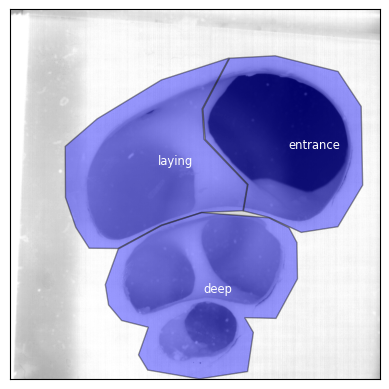

In [57]:
fig = plot_chambers(ROI_dict)

In [58]:
figure_path = f'../{run_name}/plots/{run_name}_ROI.pdf'
save_figure(fig, figure_path)

Figure saved to: p:\Anaysis\Inshell\202407\plots\202407_ROI.pdf


In [59]:
# get the width and height of the frame (add ",c" before = for non-argos runs)
height, width= backgd_img.shape
# this is needed as our position coordinates are normalized between 0 and 1 while our ROI coordinates are not
height, width

(2048, 2048)

In [60]:
# apply the above function to the x and y coordinates in each row of our larvae dataframe
# Add + n to "larvae["dpf"] = larvae["dpf"]" if the run is started later than 0 dpf
larvae = add_ROI_col(larvae, width, height, ROI_dict)
larvae["dpf"] = larvae["dpf"]

## Tallying larvae numbers

In [61]:
larvae_table = pd.pivot_table(larvae, values='frame', index=['time_of_day', 'dpf'],
                    columns=['ROI'], aggfunc="count", fill_value=0)
larvae_table.reset_index(inplace=True)
larvae_table = larvae_table.rename_axis(None, axis=1)
larvae_table

,time_of_day,dpf,deep,entrance,laying,outside
0,2024-07-16 10:13:17,0,0,0,1,0
1,2024-07-16 10:20:18,0,0,0,1,0
2,2024-07-16 10:34:20,0,0,0,6,0
3,2024-07-16 10:48:22,0,0,0,10,0
4,2024-07-16 10:55:23,0,0,0,11,0
...,...,...,...,...,...,...
2310,2024-07-27 23:30:28,11,0,6,2,0
2311,2024-07-27 23:37:29,11,0,6,1,0
2312,2024-07-27 23:44:30,11,0,5,4,0
2313,2024-07-27 23:51:31,11,0,4,1,0


In [62]:
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
larvae_table.to_csv(f'../{run_name}/data/{run_name}_{model}_tallies_raw_{timestamp_now}.csv', index=False)

# Checkpoint: tally table

In [76]:
# TO LOAD IN TALLIES CSV
run_name='202405'
larvae_table = pd.read_csv(f'../{run_name}/data/202405_model6_tallies_raw_20240807_151020.csv')

In [77]:
larvae_table.head

<bound method NDFrame.head of               time_of_day  dpf  deep  entrance  laying  outside
0     2024-05-15 17:55:58    2     1         0       4        0
1     2024-05-15 18:02:59    2     1         0       5        0
2     2024-05-15 18:17:01    2     1         0       7        0
3     2024-05-15 18:24:02    2     1         0       5        0
4     2024-05-15 18:31:03    2     1         0       1        0
...                   ...  ...   ...       ...     ...      ...
1629  2024-05-25 13:20:18   12     0         4       4        0
1630  2024-05-25 13:27:19   12     1         1       4        0
1631  2024-05-25 13:34:20   12     0         1       4        0
1632  2024-05-25 13:41:21   12     1         2       7        0
1633  2024-05-25 13:48:22   12     0         2       4        0

[1634 rows x 6 columns]>

### larvae numbers

In [78]:
# dividing all the larvae counts by the maximum in each chamber (normalising)
chamber_names = ['entrance', 'laying', 'deep']
larvae_table_normalized = larvae_table.copy()
maximum_tally = larvae_table_normalized[chamber_names].max()
larvae_table_normalized[chamber_names] /= maximum_tally

In [79]:
# create a total column for totla larvae in all chambers 
larvae_table['total']= larvae_table['deep'] + larvae_table['laying'] + larvae_table['entrance']

In [80]:
# max number of larvae seen at one time
max_larvae=larvae_table['total'].max()

In [81]:
# maximum tally is a summary of the max number of larvae in each chamber
maximum_tally['total']=max_larvae
chambers= maximum_tally.index
maximum_tally

entrance     8
laying      18
deep        32
total       32
dtype: int64

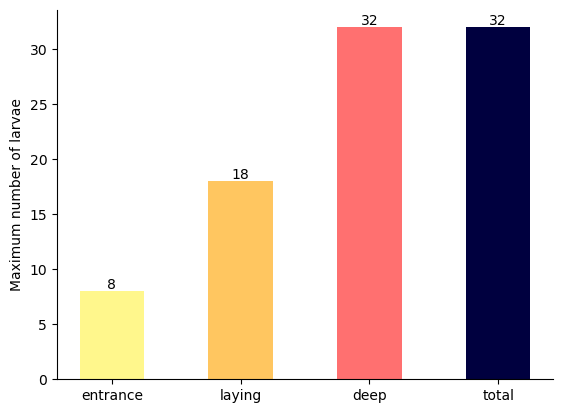

In [82]:
# plot Max for each chamber for suppliments 
c = [plotting_utils.ENTRANCE_COLOR, plotting_utils.LAYING_COLOR, plotting_utils.DEEP_COLOR, '#00003f']

fig, ax = plt.subplots()
ax.bar(chambers, maximum_tally, 0.5, color=c)

# Add the values on top of each bar
for i, value in enumerate(maximum_tally):
    ax.text(i, value, str(value), ha='center', va='bottom')

# Label your axes (optional)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Maximum number of larvae')

# Show the plot
plt.show()

In [68]:
# get current timestamp, which is used as part of the saved figure's file name (to avoid overwriting the same file)
figure_path = f'../{run_name}/plots/{run_name}_{model}_larvae_counts.pdf'

# save figure (either as png or pdf)
fig.savefig(figure_path, bbox_inches='tight')
print('Figure saved to:', os.path.abspath(figure_path))

Figure saved to: p:\Anaysis\Inshell\202407\plots\202407_model6_larvae_counts.pdf


In [83]:
emergence = larvae_table[(larvae_table['dpf'] > 7) & (larvae_table['entrance'] >= 2)].head(1)
enter_laying = larvae_table[(larvae_table['dpf'] > 4) & (larvae_table['laying'] >= 2)].head(1)
enter_deep = larvae_table[(larvae_table['dpf'] > 2) & (larvae_table['laying'] <= 0)].head(1)

In [84]:
print(emergence)
print(enter_laying)
print(enter_deep)

             time_of_day  dpf  deep  entrance  laying  outside  total
983  2024-05-22 08:28:01    9    11         3       4        0     18
             time_of_day  dpf  deep  entrance  laying  outside  total
659  2024-05-20 17:49:04    7    22         0       2        0     24
            time_of_day  dpf  deep  entrance  laying  outside  total
51  2024-05-16 00:12:59    3     5         0       0        0      5


In [71]:
emergence_line = emergence["time_of_day"].values[0]
emergence_line

numpy.datetime64('2024-07-25T08:14:00.000000000')

## Create Plots

### Vertical Line Plot

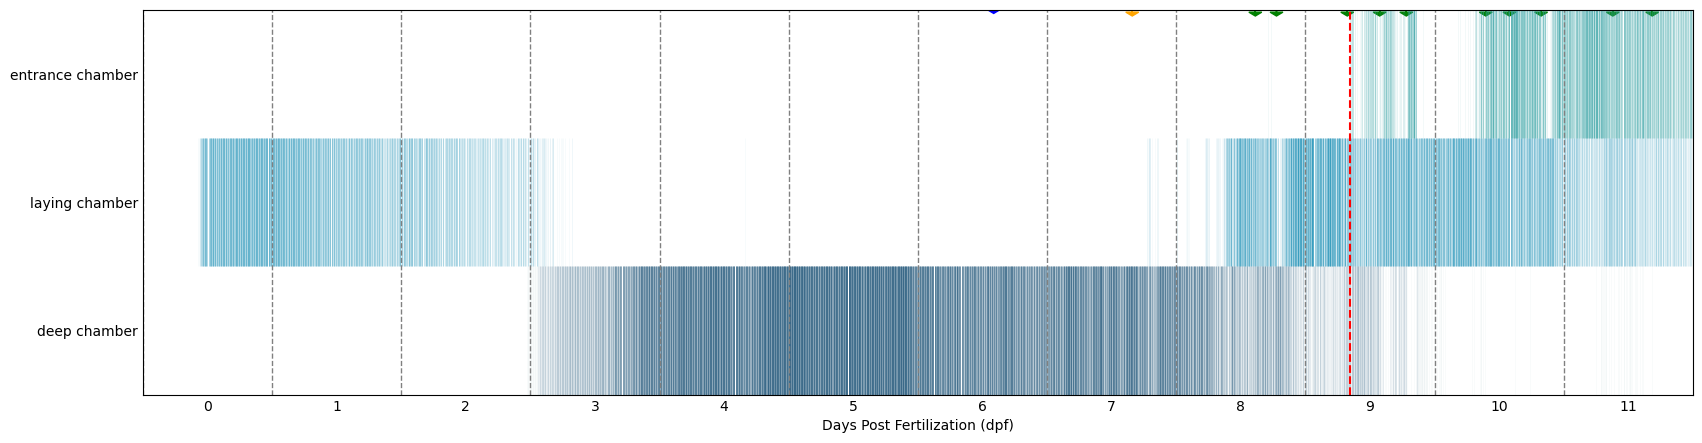

In [73]:
import matplotlib.dates as md
fig_vertical_line_plot = plot_vertical_line_plot(larvae_table_normalized, larvae_table)

# fresh water added 20240722_1405
# momectomy 20240723_15:50
plt.arrow(dt.datetime(year=2024, month=7, day=22, hour=14, minute=5, second=23),3.5, 0, -0.5, color='blue',length_includes_head=False,head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=23, hour=15, minute=50, second=00),3.5, 0, -0.55, color='orange',length_includes_head=True, head_width=0.1, head_length=0.03)

#feeding: 
plt.arrow(dt.datetime(year=2024, month=7, day=24, hour=14, minute=42, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=24, hour=18, minute=38, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=25, hour=7, minute=47, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=25, hour=13, minute=48, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=25, hour=18, minute=45, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=26, hour=9, minute=31, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=26, hour=13, minute=55, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=26, hour=19, minute=48, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=27, hour=9, minute=7, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)
plt.arrow(dt.datetime(year=2024, month=7, day=27, hour=16, minute=27, second=5),3.5, 0, -0.55, color='green',length_includes_head=True, head_width=0.1, head_length=0.03)

#emergence
plt.axvline(x=emergence_line, color='red', linestyle='--')

plt.show()

In [74]:
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_{model}_chamberplot_{timestamp_now}.pdf'
save_figure(fig_vertical_line_plot, figure_path)

Figure saved to: p:\Anaysis\Inshell\202407\plots\202407_model6_chamberplot_20240807_183757.pdf


#### 202107 missing data

In [ ]:
larvae_table_normalized

In [ ]:
#202107 only
fig_vertical_line_plot = plot_vertical_line_plot(larvae_table_normalized, df)
ax = fig_vertical_line_plot.axes[0]
ax.axvline(dt.datetime(year=2021, month=7, day=1, hour=0, minute=0, second=0), color='grey',linestyle='--', linewidth=1)
correct_dpfs = []
for i in range(12):
   x = dt.datetime(year=2021, month=6, day=25, hour=12, minute=0, second=0)+ dt.timedelta(hours=24 * i)
   correct_dpfs.append(x)
ax.set_xticks(correct_dpfs)
ax.set_xticklabels(range(12))

#Any markers needed?
#3:55 02.07.2021 momectomy
plt.arrow(dt.datetime(year=2021, month=7, day=2, hour=15, minute=55, second=0),3.5, 0, -0.6, color='orange',length_includes_head=True, head_width=0.5, head_length=0.3)


plt.show()

#### Save chamberplot

In [ ]:
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_chamberplot_{timestamp_now}.pdf'
save_figure(fig_vertical_line_plot, figure_path)

### Dot Plot

In [ ]:
# We need the xy coordinates and the reference figure (variable backgd_img)

reference_frame_path = f'../{run_name}/data/{run_name}_reference_frame.JPEG'
backgd_img = plt.imread(reference_frame_path) # load backround frame to plot ROIs on
height, width = backgd_img.shape

xpos_unnormalized = np.array(larvae['xcenter_normalized'])*width
ypos_unnormalized = np.array(larvae['ycenter_normalized'])*height

plt.imshow(backgd_img, cmap='gray')
# TODO : add custom colorbar to explain the meaning of the color
plt.scatter(xpos_unnormalized, ypos_unnormalized, s=0.1, c=larvae['time_of_day'], cmap = "viridis_r" )
plt.colorbar()
plt.xticks([])
plt.yticks([])
figure = plt.gcf()
plt.show()

#### Save figure 

In [ ]:
# get current timestamp, which is used as part of the saved figure's file name (to avoid overwriting the same file)
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/{run_name}_dotplot_{timestamp_now}.pdf'

# save figure (either as png or pdf)
figure.savefig(figure_path, bbox_inches='tight')
print('Figure saved to:', os.path.abspath(figure_path))

### KDE Plot

In [ ]:
ROI_file_path = f'../{run_name}/data/{run_name}.json'
ROI_dict = get_ROI_dict(ROI_file_path)
kde_folder_path = f'../{run_name}/data/kde_values'
bandwidth = 0.8
print(kde_folder_path)

In [ ]:
fit_kde_model_per_dpf(larvae, width, height, ROI_dict, kde_folder_path, density_bandwidth=bandwidth)

In [ ]:
fig_kde = plot_kde_dpf_plot(larvae,
                        width,
                        height,
                        ROI_dict,
                        backgd_img,
                        kde_folder_path,
                        bandwidth=bandwidth,
                        vmin=1e-5,
                        vmax=2.8e-05,
                        crop_xmin=0,
                        crop_xmax=width,
                        crop_ymin=0,
                        crop_ymax=height,
                        alpha=0.8,
                        log_scale=False)
plt.show()

In [ ]:
timestamp_now = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
figure_path = f'../{run_name}/plots/kde_plot_{timestamp_now}.png'
save_figure(fig_kde, figure_path)